In [1]:
import pickle
X_acl,X_ppg,y,y_participant = pickle.load(open('../data/tabular_data.p','rb'))

In [2]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [3]:
for k in range(X_ppg.shape[0]):
    X_ppg[k] = MinMaxScaler().fit_transform(X_ppg[k])

In [4]:
import numpy as np
X_ppg = X_ppg[:,np.arange(0,512,2),:]

X_acl = np.concatenate([X_ppg,X_acl],axis=-1)

y = X_ppg[:,:,0].reshape(-1,256,1)
X_acl = X_acl[:,:,:1]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional
from keras.models import Model, Sequential

In [6]:
logo = LeaveOneGroupOut()
logo = LeavePGroupsOut(n_groups=5)
for train_index, test_index in logo.split(X_acl, y, y_participant.reshape(-1)):
    train_x, test_x = X_acl[train_index], X_acl[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_participant, test_participant = y_participant[train_index], y_participant[test_index]
    break
train_x.shape,train_y.shape
pickle.dump([train_participant,test_participant],open('../data/participant_split_for_BRDAE.p','wb'))

In [7]:
from joblib import Parallel,delayed

def random_noise(x):
    return x+(1/3)*np.random.normal(0,1,x.shape)

def sloping_noise(x):
    x = x.copy()
    def corrupt_single(xx):
        xx_temp = np.random.uniform(-1,1)
        xx_temp = np.array([xx_temp]*256).reshape(256,1)
        index = np.arange(0,256,1).reshape(256,1)
        return xx+(4/250)*np.multiply(index,xx_temp)

    for i in range(x.shape[0]):
        x[i] = corrupt_single(x[i])
    return x


def saturation_noise(x):
    x = x.copy()
    for i in range(x.shape[0]):
        low = np.random.randint(0,216)
        high = np.random.randint(low,min(256,np.random.randint(low+1,low+51)))
        x[i][low:high,0] = np.random.randint(0,2)
    return x

def generate_combinations(x):
    functions = [random_noise,saturation_noise,sloping_noise]
    indicator = np.random.randint(0,2,3)
#     indicator = [1,1,1]
    for j,i in enumerate(indicator):
        if i==1:
            x = functions[j](x)
    return x


def generate_corrupt_all(train_x,n):
    X = Parallel(n_jobs=20,verbose=2)(delayed(generate_combinations)(train_x.copy()) for i in range(n))
    return np.concatenate(X)

n = 50
train_y = np.concatenate([train_x]*n)
train_x = generate_corrupt_all(train_x,n=n)
 


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done  37 out of  50 | elapsed:    6.6s remaining:    2.3s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    8.6s finished


In [8]:
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size = 0.2,random_state=42)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape),(test_x.shape,test_y.shape)

(((1162680, 256, 1), (1162680, 256, 1)),
 ((290670, 256, 1), (290670, 256, 1)),
 ((14296, 256, 1), (14296, 256, 1)))

In [9]:
def get_model(input_shape=(256,1),act='tanh',loss="mae",opt='adam',n_classes=1):
    model =  Sequential()
    model.add(Conv1D(100,10,input_shape=input_shape,activation='tanh',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(5))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(50,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPool1D(2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Reshape((10,2)))
    model.add(Conv1D(100,2,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(256,2,input_shape=input_shape,activation='tanh',kernel_initializer='normal',padding='same'))
    model.add(Reshape((256,10)))
    model.add(TimeDistributed(Dense(1,activation='sigmoid')))
#     model.add(Dense(64,activation='relu'))
#     model.add(Dense(128,activation='tanh'))
#     model.add(Dense(256,activation='sigmoid'))
#     model.add(Reshape((256,1)))
    
    
#     model.add(Bidirectional(LSTM(100,return_sequences=True,activation='tanh',kernel_initializer='normal')))
#     model.add(TimeDistributed(Dense(1,activation='')))
    model.compile(loss=loss,optimizer=opt)
    return model

def get_model_LSTM(input_shape=(256,1),act='tanh',loss="mse",opt='adam',n_classes=1):
    model = Sequential()
    model.add(GaussianNoise(stddev=1))
    model.add(Bidirectional(LSTM(40,return_sequences=True,
                      activation='tanh',input_shape=input_shape)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss=loss,optimizer=opt)
    return model

In [10]:
model = get_model_LSTM()

In [11]:
from keras.models import load_model
filepath = '../model_files/BRDAE_final_2.hdf5'
# model = load_model(filepath)

In [12]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=200, batch_size=1000,
          callbacks=callbacks_list,shuffle=True)

Epoch 1/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0366
Epoch 00001: val_loss improved from inf to 0.02846, saving model to ../model_files/BRDAE_final_2.hdf5
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0366 - val_loss: 0.0285
Epoch 2/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0351
Epoch 00002: val_loss improved from 0.02846 to 0.02754, saving model to ../model_files/BRDAE_final_2.hdf5
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0351 - val_loss: 0.0275
Epoch 3/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0348
Epoch 00003: val_loss improved from 0.02754 to 0.02612, saving model to ../model_files/BRDAE_final_2.hdf5
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0348 - val_loss: 0.0261
Epoch 4/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0346
Epoch 00004: val_loss did not improve from 0.02612
1163/1163 [=========================

Epoch 35/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0335
Epoch 00035: val_loss did not improve from 0.02363
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0335 - val_loss: 0.0240
Epoch 36/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0335
Epoch 00036: val_loss did not improve from 0.02363
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0335 - val_loss: 0.0240
Epoch 37/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0335
Epoch 00037: val_loss improved from 0.02363 to 0.02335, saving model to ../model_files/BRDAE_final_2.hdf5
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0335 - val_loss: 0.0233
Epoch 38/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0335
Epoch 00038: val_loss did not improve from 0.02335
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0335 - val_loss: 0.0243
Epoch 39/200
1163/1163 [=====================

Epoch 71/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0333
Epoch 00071: val_loss did not improve from 0.02332
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0333 - val_loss: 0.0237
Epoch 72/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0333
Epoch 00072: val_loss did not improve from 0.02332
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0333 - val_loss: 0.0239
Epoch 73/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0333
Epoch 00073: val_loss did not improve from 0.02332
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0333 - val_loss: 0.0240
Epoch 74/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0333
Epoch 00074: val_loss did not improve from 0.02332
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0333 - val_loss: 0.0241
Epoch 75/200
1163/1163 [==============================] - ETA: 0s - loss: 0.0333
Epoch 00075: val_lo

In [13]:
filepath = '../model_files/BRDAE_final_2.hdf5'
model = load_model(filepath)

In [14]:
test_y_pred = model.predict(test_x)

In [15]:
for k in range(test_y_pred.shape[0]):
    test_y_pred[k]  = MinMaxScaler().fit_transform(test_y_pred[k])

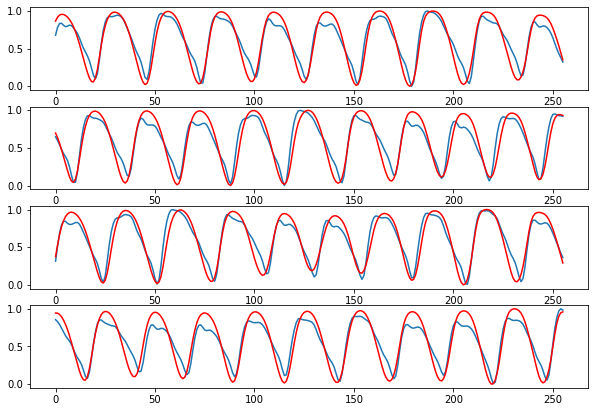

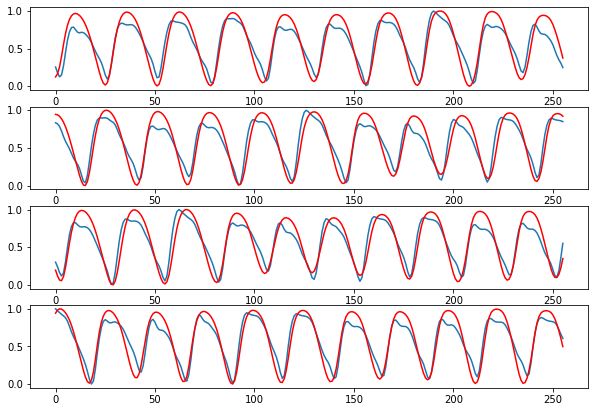

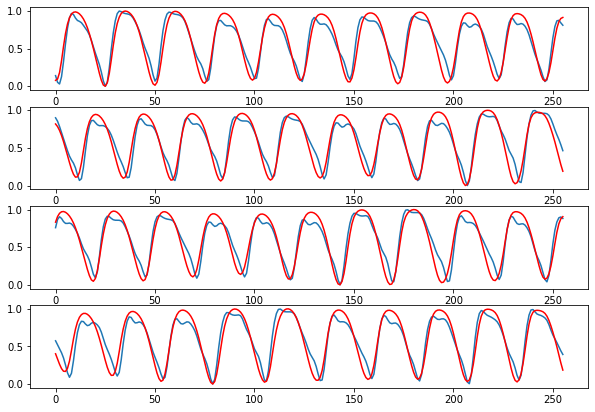

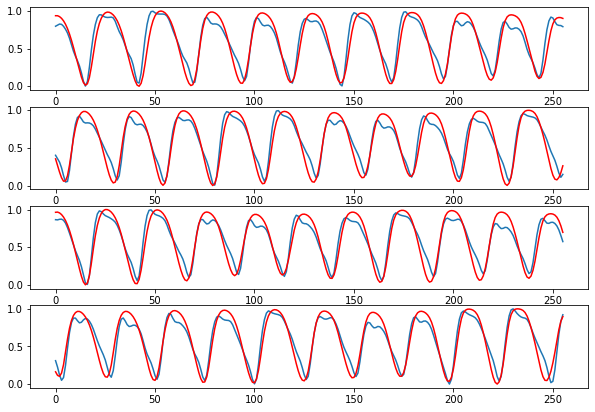

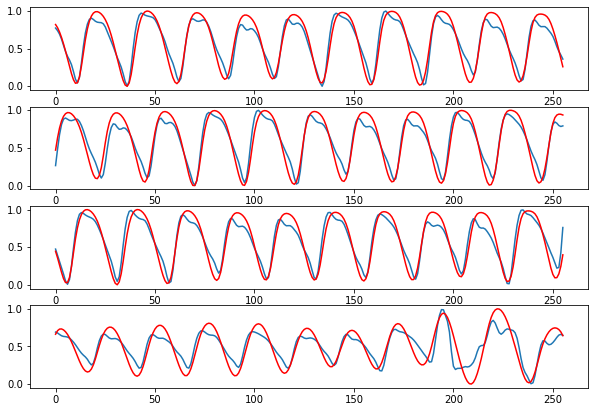

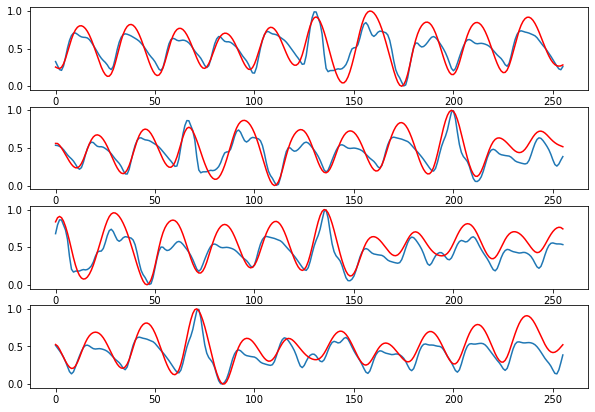

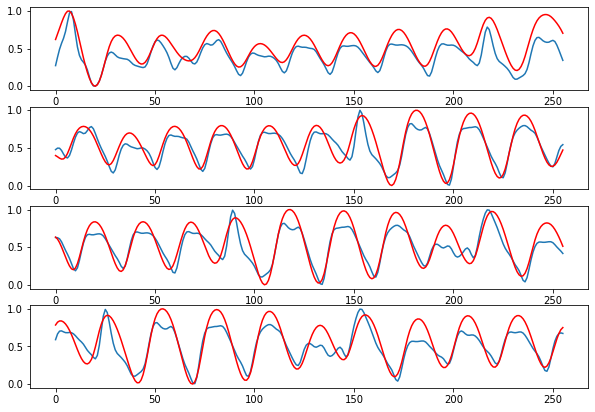

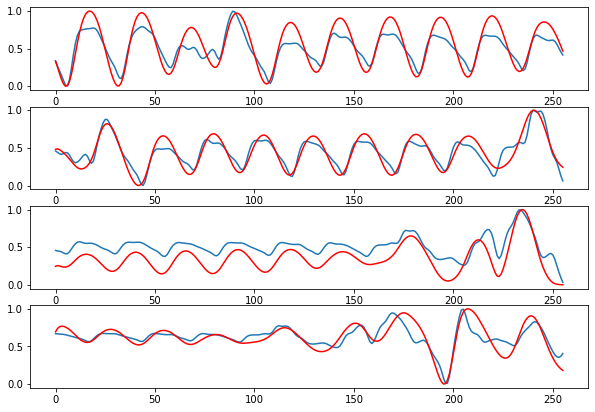

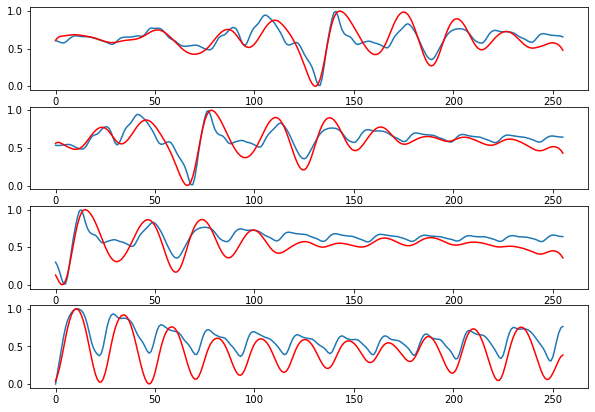

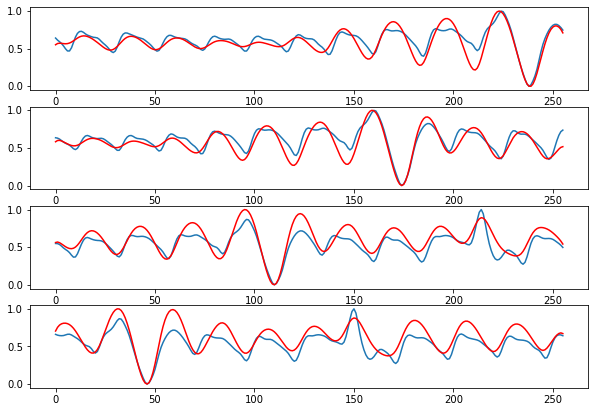

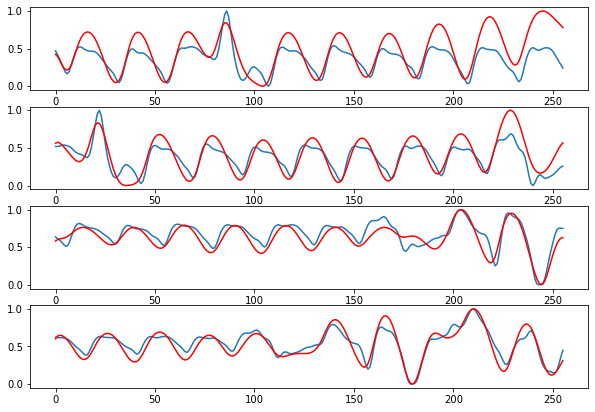

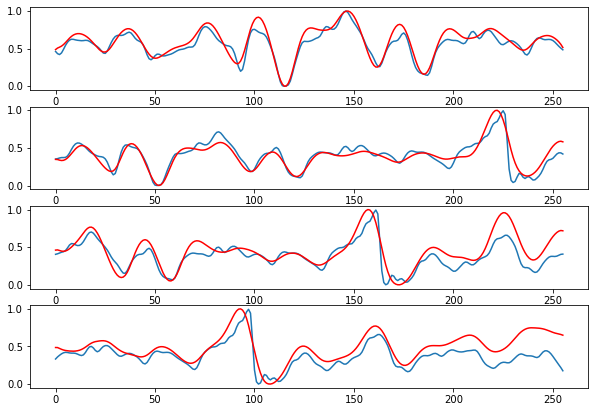

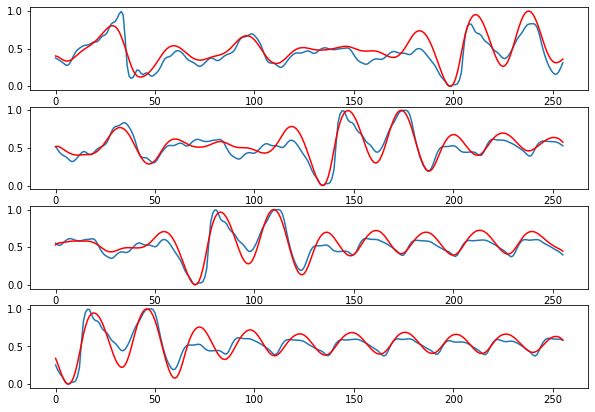

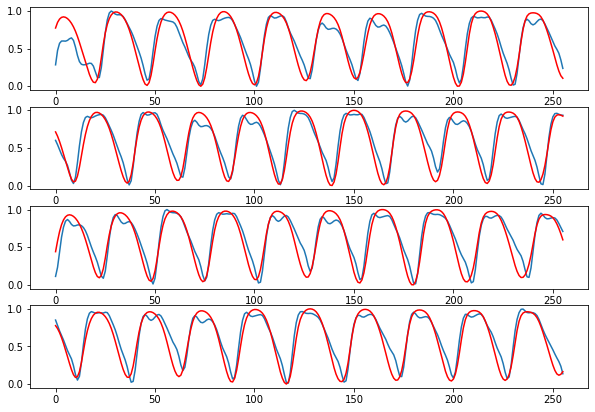

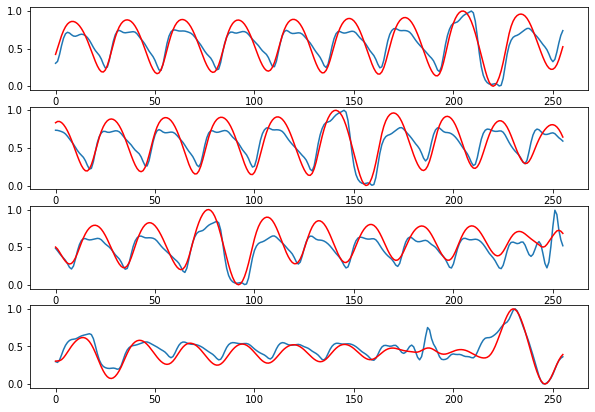

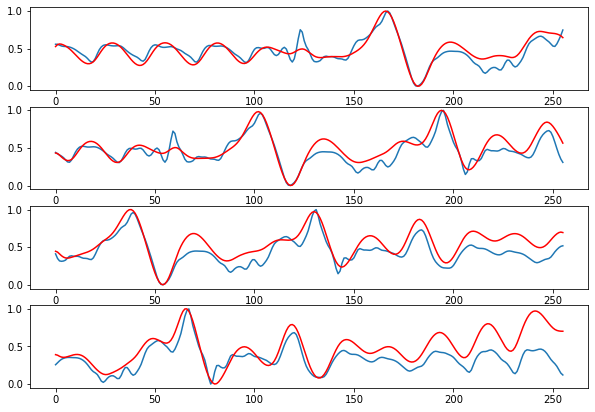

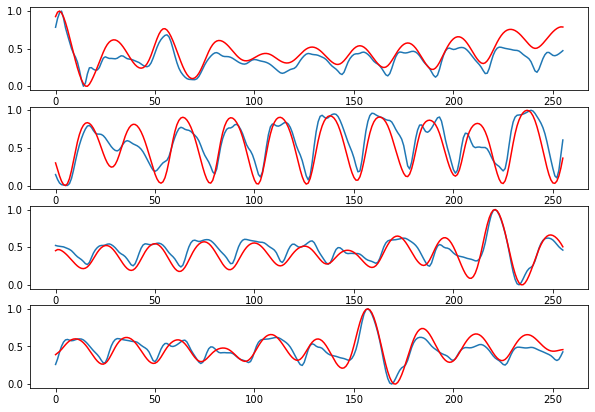

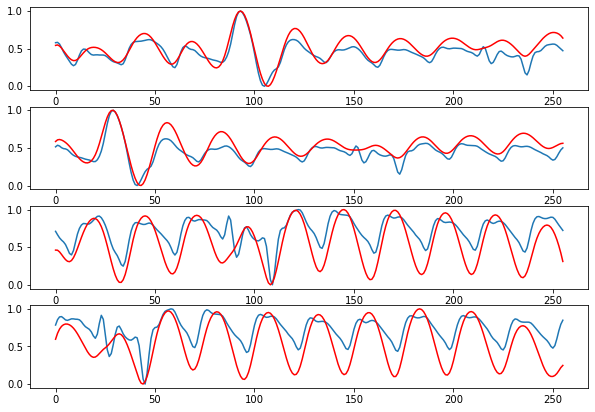

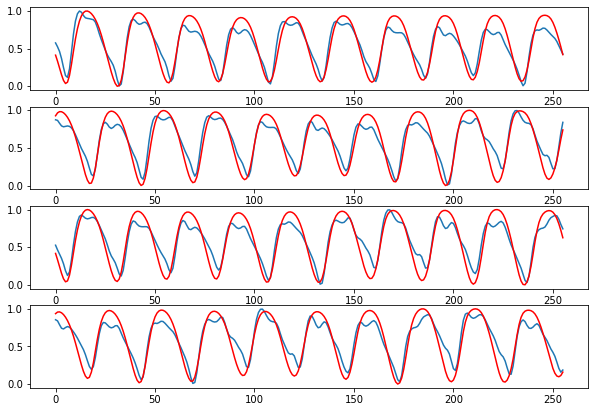

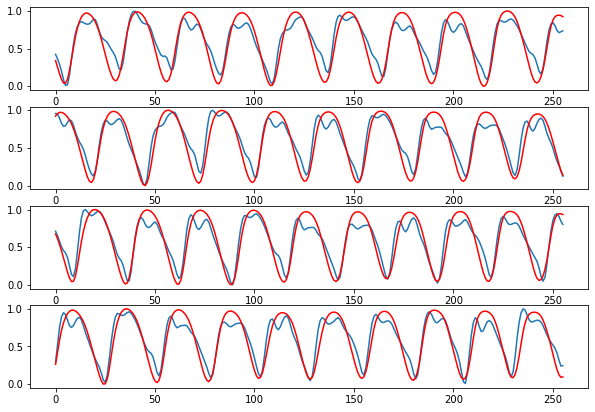

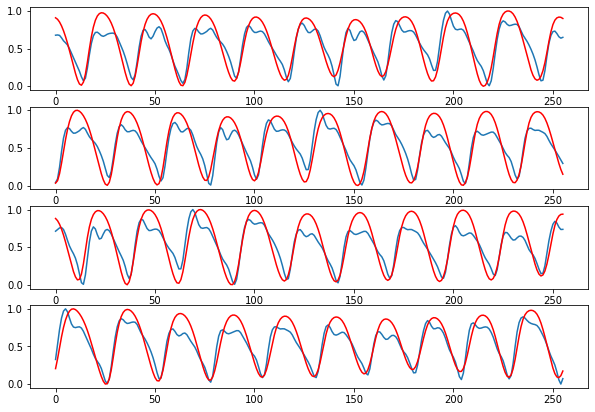

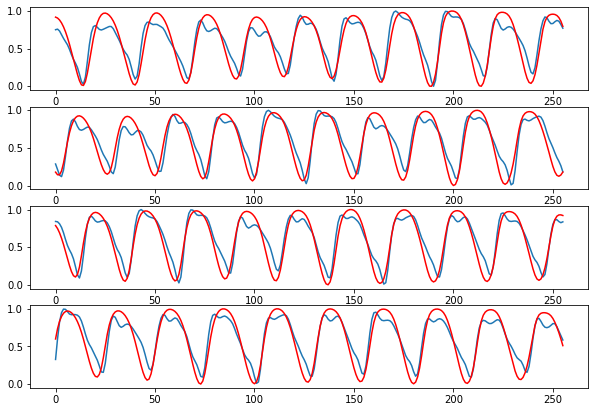

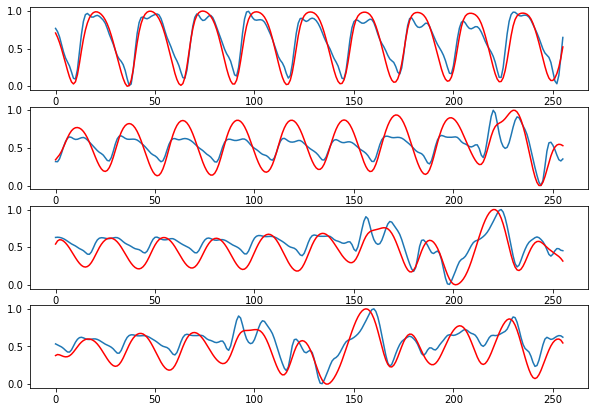

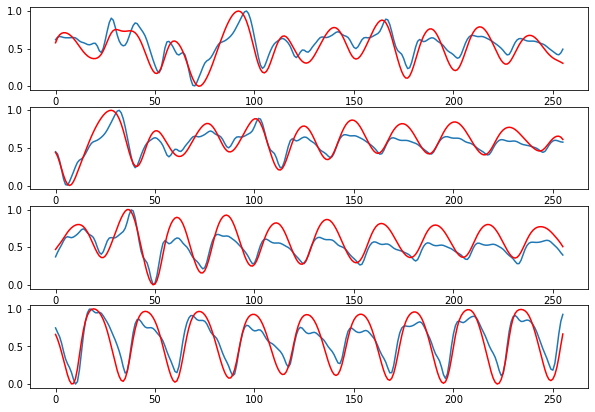

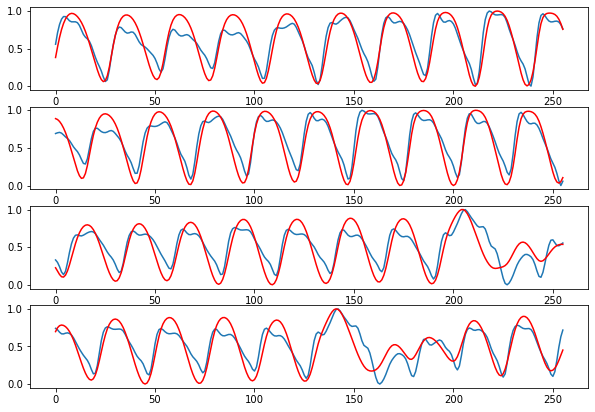

In [18]:
%matplotlib inline
for i in range(200,300,4):
    
    fig,ax = plt.subplots(4,1,figsize=(10,7))
    ax[0].plot(test_y[i])
    ax[0].plot(test_y_pred[i],'r')
    ax[1].plot(test_y[i+1])
    ax[1].plot(test_y_pred[i+1],'r')
    ax[2].plot(test_y[i+2])
    ax[2].plot(test_y_pred[i+2],'r')
    ax[3].plot(test_y[i+3])
    ax[3].plot(test_y_pred[i+3],'r')
    
    plt.show()